In [1]:
import matplotlib.pyplot as plt
import pandas as  pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, roc_curve, auc

c:\Users\sergi\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
base = pd.read_json('../data/predictions/base.json')
large_base = pd.read_json('../data/predictions/large_base.json')
extra = pd.read_json('../data/predictions/external.json')
large_extra = pd.read_json('../data/predictions/large_external.json')
ner = pd.read_json('../data/predictions/ner_mask.json')
large_ner = pd.read_json('../data/predictions/large_ner.json')
noise = pd.read_json('../data/predictions/noise.json')
large_noise = pd.read_json('../data/predictions/large_noise.json')
full_length = pd.read_json('../data/predictions/full_length.json')
large_full = pd.read_json('../data/predictions/large_full_length.json')
final = pd.read_json('../data/predictions/backtranslation.json')
large_final = pd.read_json('../data/predictions/large_backtranslation.json')

FileNotFoundError: File ../data/predictions/base.json does not exist

In [ ]:
import sys
sys.path.append('..')
from utils import LABELS

models = [base, full_length, final]
nombres = ['Base', 'Long context', 'Backtranslation']

def get_confusion_matrix(df, name):
    cm = confusion_matrix(df['category'], df['predictions'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=LABELS.keys())
    disp.plot()
    plt.title(name)
    plt.show()

#for model, nombre in zip(models, nombres):
#    get_confusion_matrix(model, nombre)

## Acierto

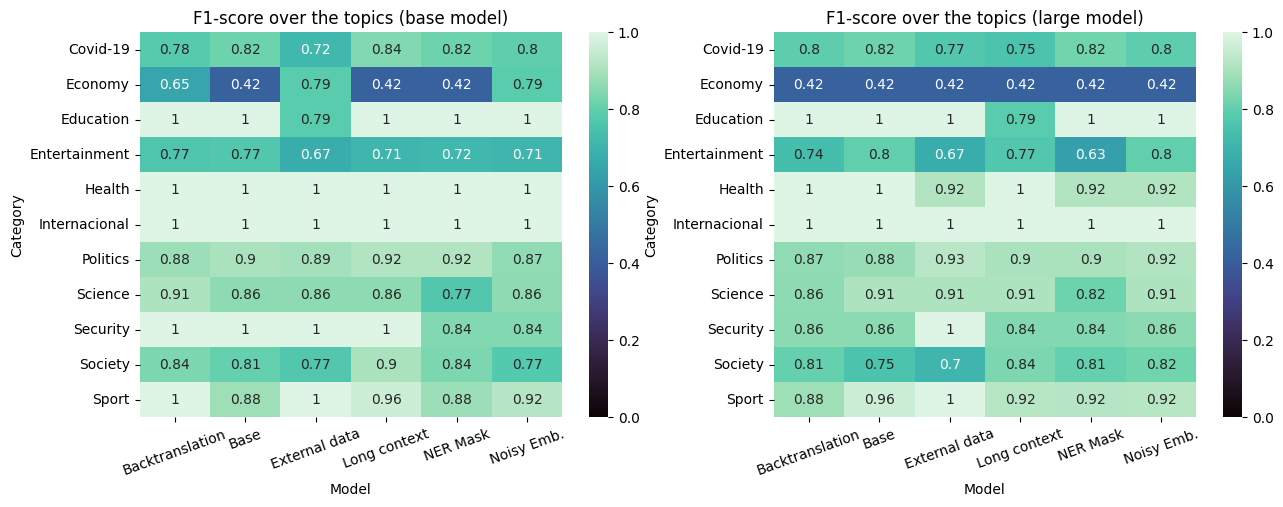

In [ ]:
import seaborn as sns
from utils import LABELS

def get_report(data):
    report = {}
    for topic in data['topic'].unique():
        subset = data[data['topic'] == topic]
        report[topic] = classification_report(subset['category'].apply(lambda x: LABELS[x]), 
                                              subset['predictions'].apply(lambda x: LABELS[x]),
                                    labels=np.arange(2).tolist(),
                                    target_names=['Fake','True'],
                                    digits=4,
                                    zero_division=0,
                                    output_dict=True)
    return report


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
models = [base,extra,full_length,ner,noise,final]
reports = [get_report(model) for model in models]
f1 = [[report[topic]['macro avg']['f1-score'] for topic in report.keys()] for report in reports]

nombres = ['Base']*len(f1[0]) + ['External data']*len(f1[1]) + ['Long context']*len(f1[2]) + ['NER Mask']*len(f1[3]) + ['Noisy Emb.']*len(f1[4]) + ['Backtranslation']*len(f1[5])

data = pd.DataFrame({'Category': list(reports[0].keys())*len(reports),
                     'F1-score': [score for sublist in f1 for score in sublist],
                     'Model': nombres})
#sns.barplot(x='Category', y='F1-score', hue='Model', data=data)
sns.heatmap(data.pivot(index='Category',columns='Model',values='F1-score'), 
            annot=True, cmap='mako', # coolwarm
            vmin=0, vmax=1)
plt.xticks(rotation=20)
plt.title('F1-score over the topics (base model)')

plt.subplot(1,2,2)
models = [large_base, large_extra, large_full, large_ner, large_noise, large_final]
reports = [get_report(model) for model in models]
f1 = [[report[topic]['macro avg']['f1-score'] for topic in report.keys()] for report in reports]

nombres = ['Base']*len(f1[0]) + ['External data']*len(f1[1]) + ['Long context']*len(f1[2]) + ['NER Mask']*len(f1[3]) + ['Noisy Emb.']*len(f1[4]) + ['Backtranslation']*len(f1[5])

data = pd.DataFrame({'Category': list(reports[0].keys())*len(reports),
                        'F1-score': [score for sublist in f1 for score in sublist],
                        'Model': nombres})
#sns.barplot(x='Category', y='F1-score', hue='Model', data=data)
sns.heatmap(data.pivot(index='Category',columns='Model',values='F1-score'), 
            annot=True, cmap='mako', # coolwarm
            vmin=0, vmax=1)
plt.xticks(rotation=20)
plt.title('F1-score over the topics (large model)')

plt.show()

/tmp/ipykernel_19311/155178290.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data,pd.DataFrame({'Model': nombre, 'F1-score (%)': mean*100, 'Ponderation': 'Mean'}, index=[0])], ignore_index=True)
/tmp/ipykernel_19311/155178290.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data,pd.DataFrame({'Model': nombre, 'F1-score (%)': mean*100, 'Ponderation': 'Mean'}, index=[0])], ignore_index=True)


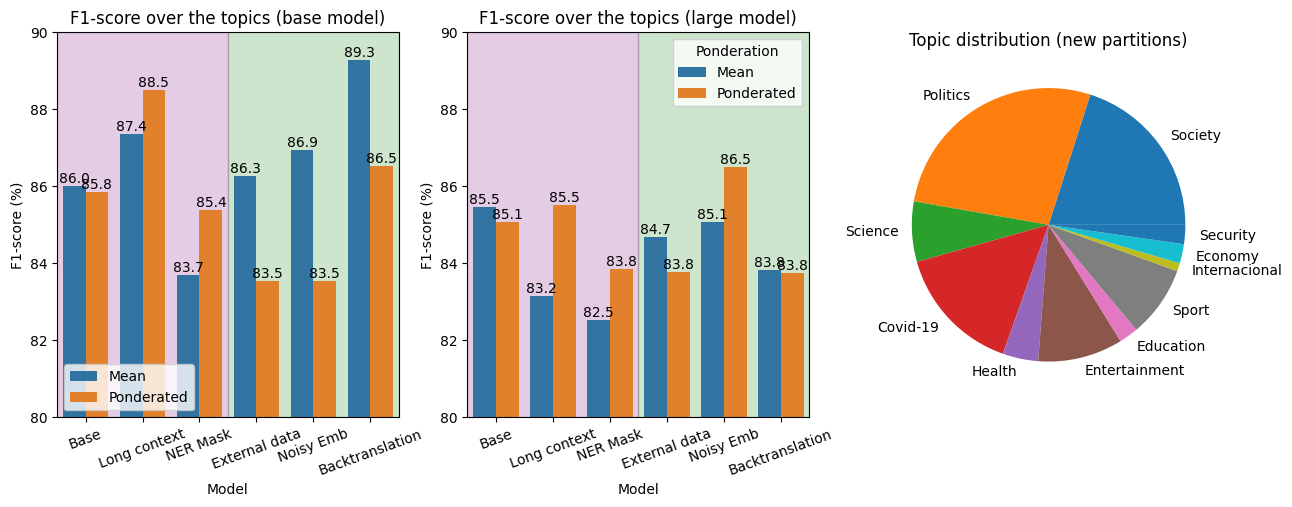

In [ ]:
def get_scores(models, nombres):
    data = pd.DataFrame(columns=['Model', 'F1-score (%)', 'Ponderation'])
    for model, nombre in zip(models, nombres):
        scores = []
        for topic in model['topic'].unique():
            subset = model[model['topic'] == topic]
            scores.append(f1_score(subset['category'], subset['predictions'], average='macro'))
        mean = np.mean(scores)
        pond = f1_score(model["category"], model["predictions"], average="macro")
        data = pd.concat([data,pd.DataFrame({'Model': nombre, 'F1-score (%)': mean*100, 'Ponderation': 'Mean'}, index=[0])], ignore_index=True)
        data = pd.concat([data,pd.DataFrame({'Model': nombre, 'F1-score (%)': pond*100, 'Ponderation': 'Ponderated'}, index=[0])], ignore_index=True)
    return data

base_scores = get_scores([base, full_length, ner, extra, noise, final],
                            ['Base', 'Long context', 'NER Mask', 'External data', 'Noisy Emb', 'Backtranslation'])
large_scores = get_scores([large_base, large_full, large_ner, large_extra, large_noise, large_final],
                            ['Base', 'Long context', 'NER Mask', 'External data', 'Noisy Emb', 'Backtranslation'])
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
ax = plt.gca()
ax.axvspan(2.5, 5.5, color='green', alpha=0.2)
ax.axvspan(-0.5, 2.5, color='purple', alpha=0.2)

chart = sns.barplot(x='Model', y='F1-score (%)', hue='Ponderation', data=base_scores)
for container in chart.containers:
    chart.bar_label(container, fmt='%.1f')
plt.legend(loc='lower left')
plt.title('F1-score over the topics (base model)')
plt.xticks(rotation=20)
plt.ylim(80,90)

plt.subplot(1,3,2)
ax = plt.gca()
ax.axvspan(2.5, 5.5, color='green', alpha=0.2)
ax.axvspan(-0.5, 2.5, color='purple', alpha=0.2)

chart = sns.barplot(x='Model', y='F1-score (%)', hue='Ponderation', data=large_scores)
for container in chart.containers:
    chart.bar_label(container, fmt='%.1f')
plt.title('F1-score over the topics (large model)')
plt.xticks(rotation=20)
plt.ylim(80,90)

plt.subplot(1,3,3)
#sns.countplot(x='topic',  data=full_length, stat='count')
counts = [len(base[base['topic'] == topic]) for topic in base['topic'].unique()]
plt.pie(counts, labels=base['topic'].unique())
plt.xticks(rotation=90)
plt.title('Topic distribution (new partitions)')
plt.show()

## Confianza

In [ ]:
from matplotlib.gridspec import GridSpec


def get_confidence_report(data, title, threshold=0.5):
    get_confidence = lambda pred: np.sqrt(np.mean(np.square(pred - threshold)))
    fig = plt.figure(figsize=(10,5))
    gs = GridSpec(2, 4, figure=fig)
    cm = np.zeros((2,2))

    fig.add_subplot(gs[0,0])
    subset = data[(data['category'] == 'Fake') & (data['predictions'] == 'Fake')]
    cm[0,0] = get_confidence(np.array(subset['prob_fake']))
    sns.histplot(subset['prob_fake'], bins=20, kde=True, stat='percent')
    plt.xlabel('Prob of Fake')
    plt.title('Fake - Fake')

    fig.add_subplot(gs[0,1])
    subset = data[(data['category'] == 'Fake') & (data['predictions'] == 'True')]
    cm[0,1] = get_confidence(np.array(subset['prob_fake']))
    sns.histplot(subset['prob_fake'], bins=10, kde=True, stat='percent')
    plt.xlabel('Prob of Fake')
    plt.title('Fake - True')

    fig.add_subplot(gs[1,0])
    subset = data[(data['category'] == 'True') & (data['predictions'] == 'Fake')]
    cm[1,0] = get_confidence(np.array(subset['prob_fake']))
    sns.histplot(subset['prob_fake'], bins=5, kde=True, stat='percent')
    plt.xlabel('Prob of Fake')
    plt.title('True - Fake')

    fig.add_subplot(gs[1,1])
    subset = data[(data['category'] == 'True') & (data['predictions'] == 'True')]
    cm[1,1] = get_confidence(np.array(subset['prob_fake']))
    sns.histplot(subset['prob_fake'], bins=20, kde=True, stat='percent')
    plt.xlabel('Prob of Fake')
    plt.title('True - True')

    big_ax = fig.add_subplot(gs[:,2:])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=LABELS.keys())
    disp.plot(ax=big_ax, colorbar=False)
    im = big_ax.imshow(cm, interpolation='nearest', cmap='viridis', vmin=0.20, vmax=0.5)
    big_ax.figure.colorbar(im, ax=big_ax)
    plt.title('Mean confidence')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


### Modelo base

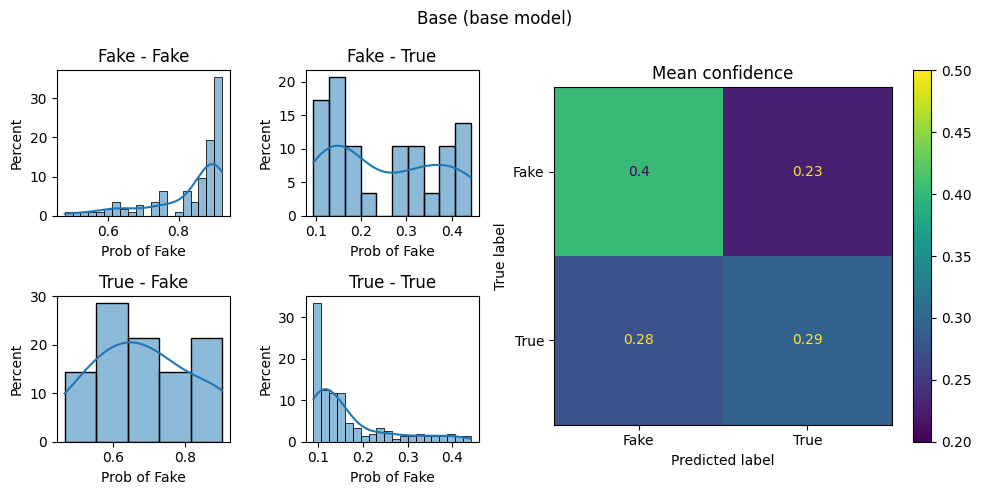

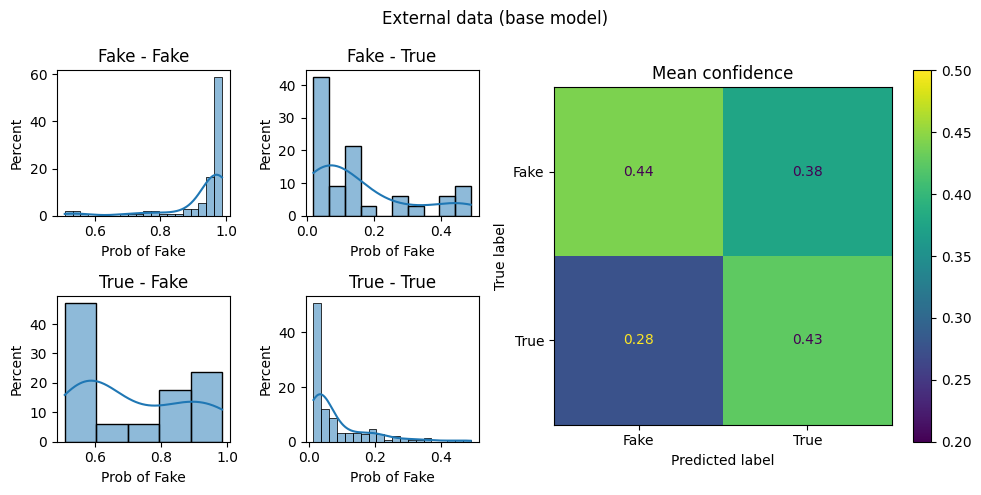

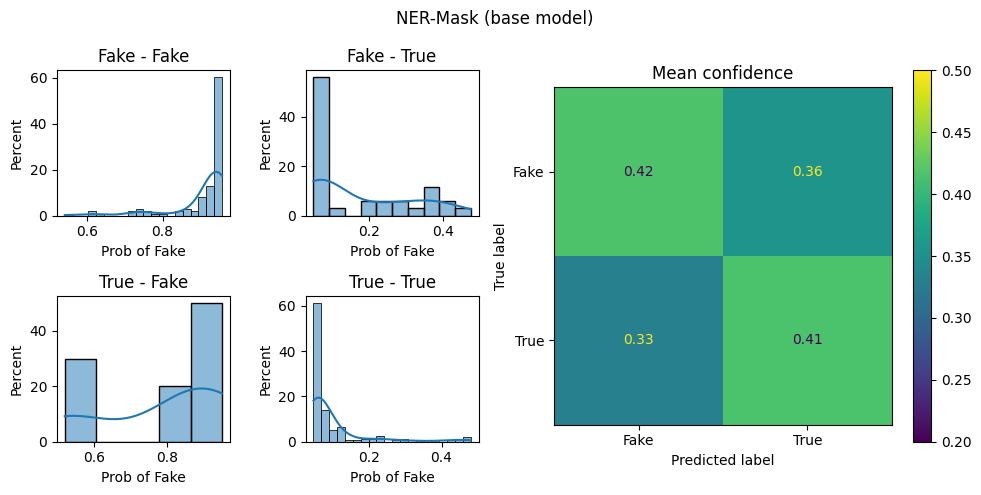

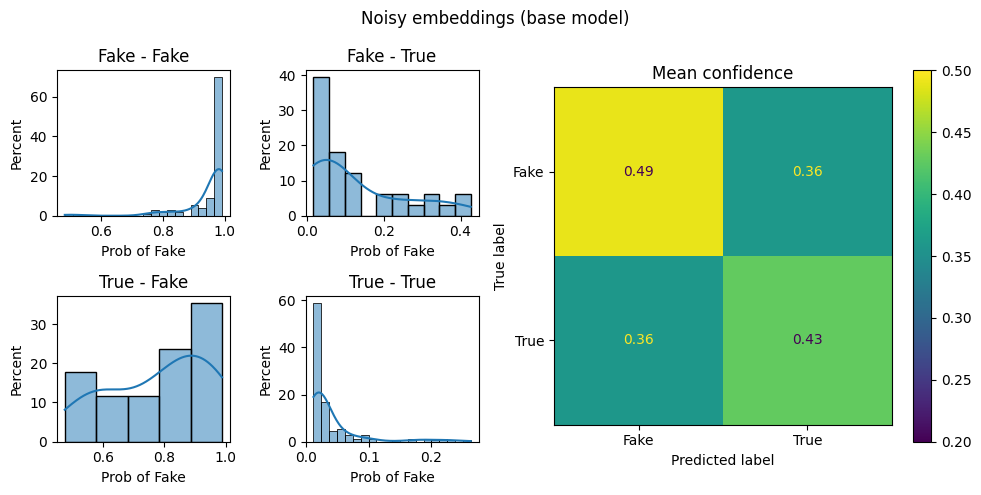

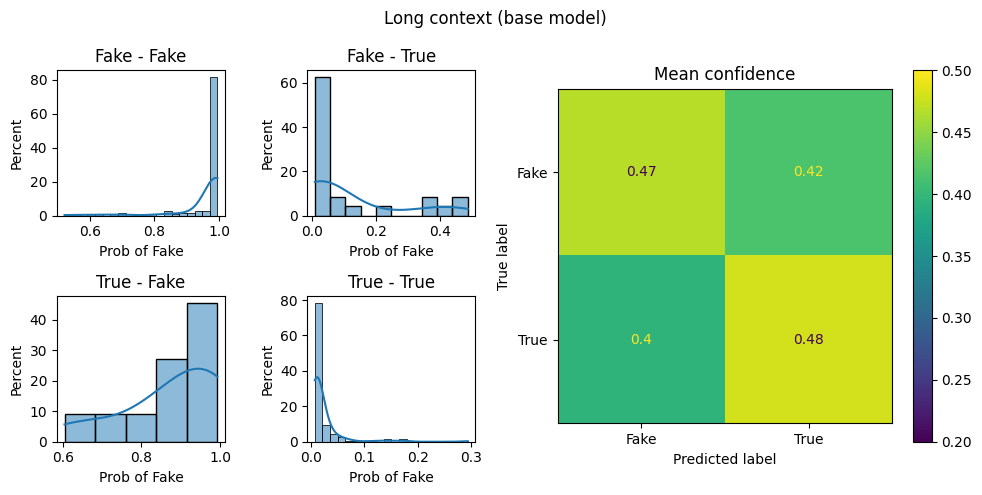

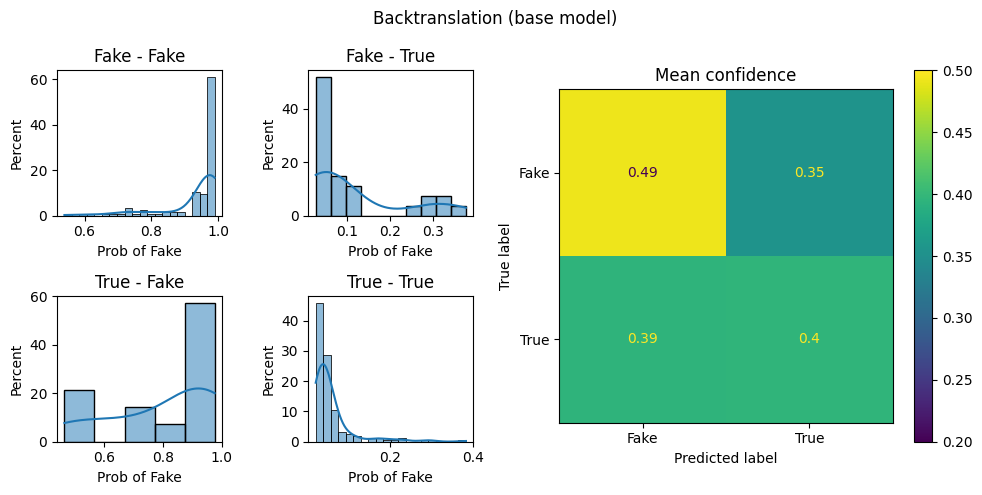

In [ ]:
get_confidence_report(base, 'Base (base model)',threshold=0.44528159499168396)
get_confidence_report(extra, 'External data (base model)')
get_confidence_report(ner, 'NER-Mask (base model)')
get_confidence_report(noise, 'Noisy embeddings (base model)',threshold=0.46455496549606323)
get_confidence_report(full_length, 'Long context (base model)')
get_confidence_report(final, 'Backtranslation (base model)', threshold=0.44906046986579895)

### Modelo grande

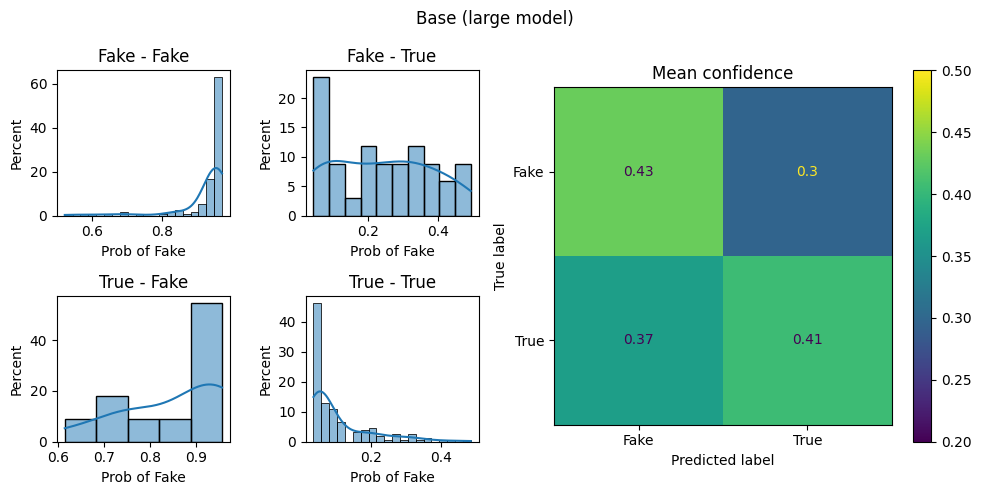

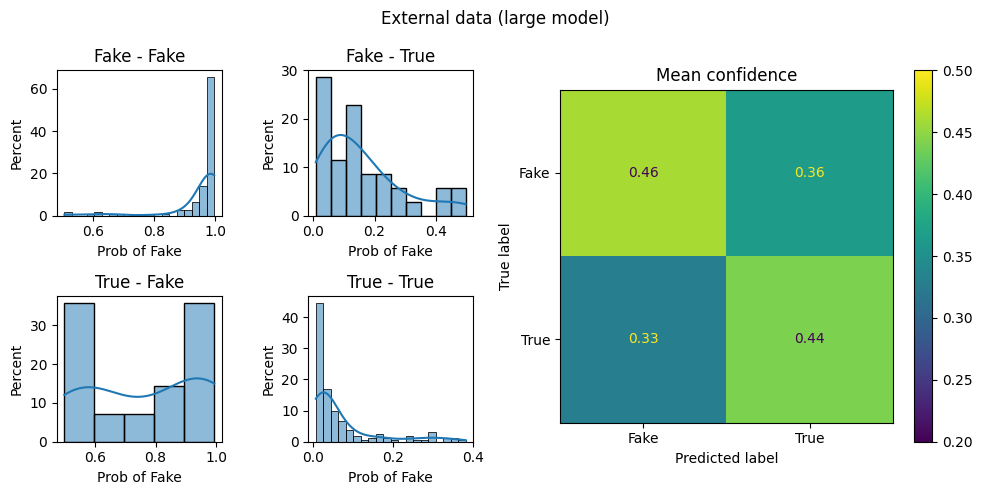

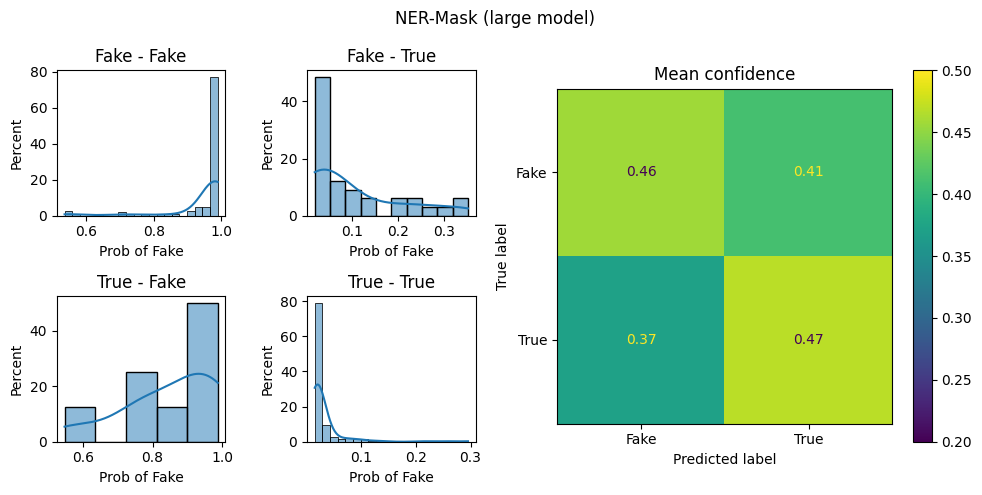

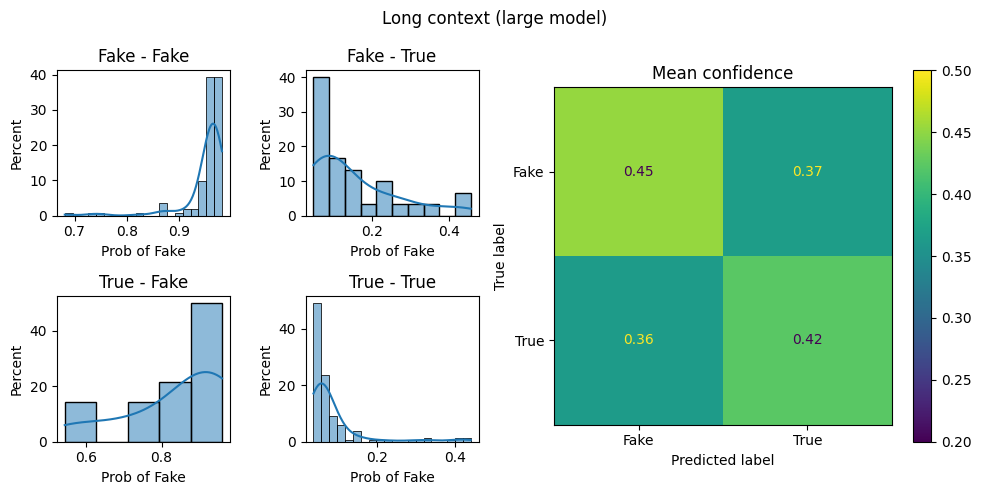

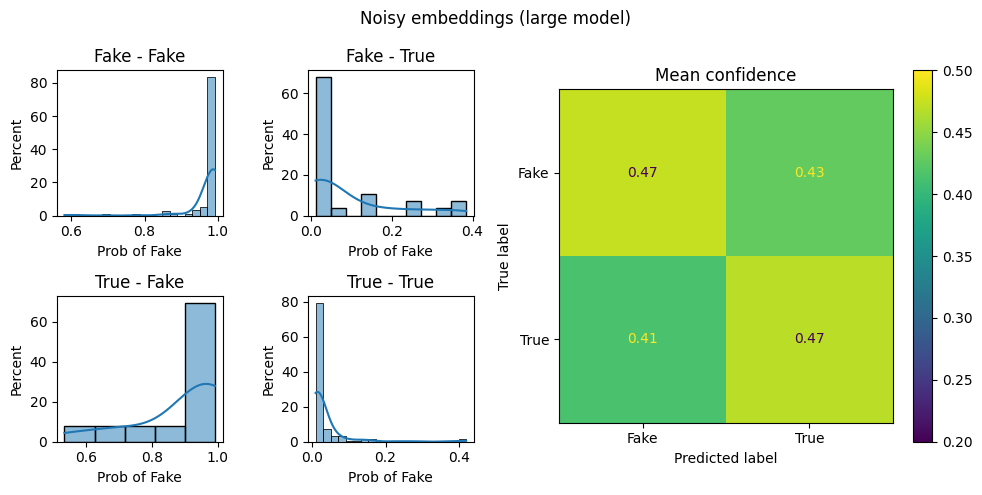

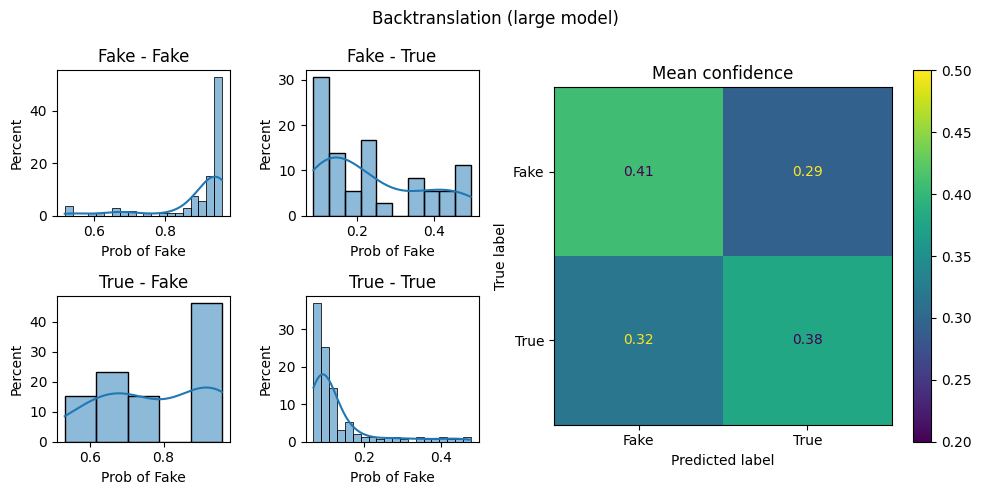

In [ ]:
get_confidence_report(large_base, 'Base (large model)')
get_confidence_report(large_extra, 'External data (large model)')
get_confidence_report(large_ner, 'NER-Mask (large model)')
get_confidence_report(large_full, 'Long context (large model)')
get_confidence_report(large_noise, 'Noisy embeddings (large model)')
get_confidence_report(large_final, 'Backtranslation (large model)')

## Curva ROC

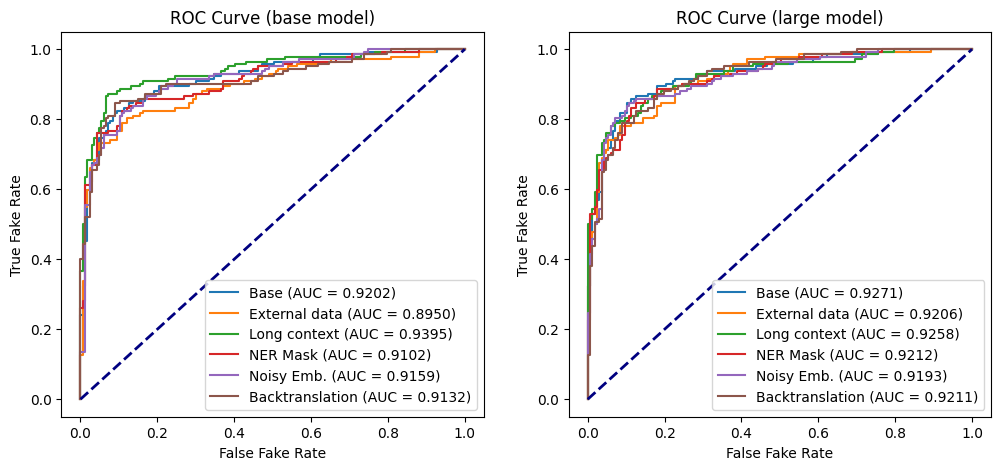

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc(models, nombres):
    for model, nombre in zip(models, nombres):
        fpr, tpr, _ = roc_curve(model['category'], model['prob_fake'], pos_label='Fake')
        plt.plot(fpr, tpr, label=f'{nombre} (AUC = {auc(fpr, tpr):.4f})')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_roc([base, extra, full_length, ner, noise, final],
         ['Base', 'External data', 'Long context', 'NER Mask', 'Noisy Emb.', 'Backtranslation'])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.xlabel('False Fake Rate')
plt.ylabel('True Fake Rate')
plt.title('ROC Curve (base model)')

plt.subplot(1,2,2)
plot_roc([large_base, large_extra, large_full, large_ner, large_noise, large_final],
         ['Base', 'External data', 'Long context', 'NER Mask', 'Noisy Emb.', 'Backtranslation'])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.xlabel('False Fake Rate')
plt.ylabel('True Fake Rate')
plt.title('ROC Curve (large model)')

plt.show()

/tmp/ipykernel_19311/2376872197.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'Topic': nombre, 'Model': topic, 'AUC': auc(fpr, tpr)}, index=[0])], ignore_index=True)
/tmp/ipykernel_19311/2376872197.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'Topic': nombre, 'Model': topic, 'AUC': auc(fpr, tpr)}, index=[0])], ignore_index=True)


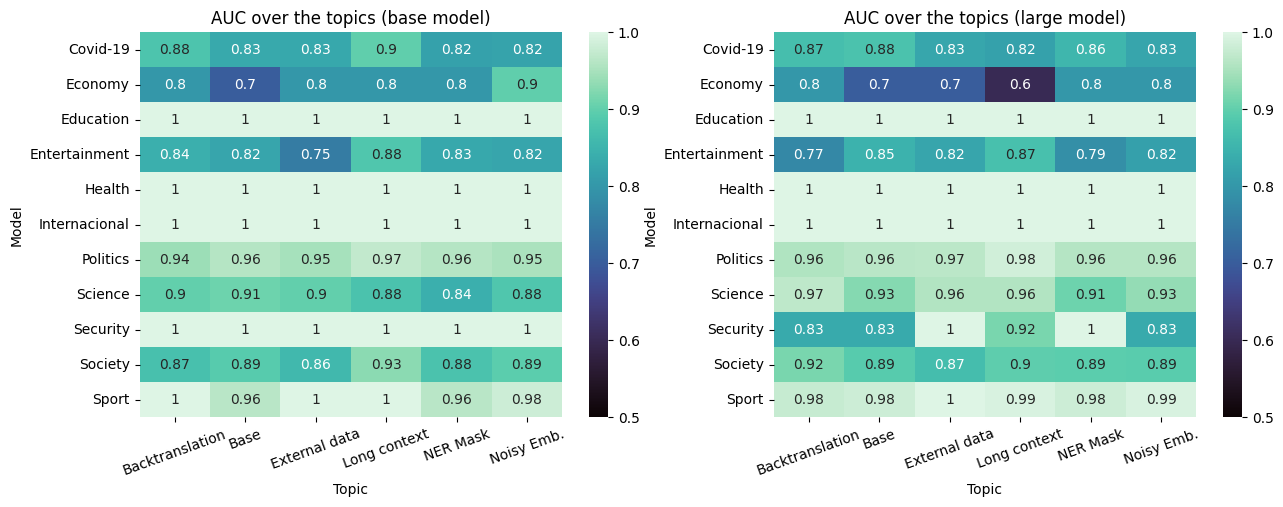

In [ ]:
def get_auc(models, nombres):
    df = pd.DataFrame(columns=['Model', 'Topic', 'AUC'])
    for model, nombre in zip(models, nombres):
        for topic in model['topic'].unique():
            subset = model[model['topic'] == topic]
            fpr, tpr, _ = roc_curve(subset['category'], subset['prob_fake'], pos_label='Fake')
            df = pd.concat([df, pd.DataFrame({'Topic': nombre, 'Model': topic, 'AUC': auc(fpr, tpr)}, index=[0])], ignore_index=True)
    return df

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
base_df = get_auc([base, full_length, ner, extra, noise, final],
                    ['Base', 'Long context', 'NER Mask', 'External data', 'Noisy Emb.', 'Backtranslation'])
sns.heatmap(base_df.pivot(index='Model', columns='Topic', values='AUC'), annot=True, cmap='mako', vmin=0.5, vmax=1)
plt.title('AUC over the topics (base model)')
plt.xticks(rotation=20)

plt.subplot(1,2,2)
large_df = get_auc([large_base, large_full, large_ner, large_extra, large_noise, large_final],
                    ['Base', 'Long context', 'NER Mask', 'External data', 'Noisy Emb.', 'Backtranslation'])
sns.heatmap(large_df.pivot(index='Model', columns='Topic', values='AUC'), annot=True, cmap='mako', vmin=0.5, vmax=1)
plt.title('AUC over the topics (large model)')
plt.xticks(rotation=20)
plt.show()

F1-score over the topics
	Mean	Ponderated
Base: 0.9165 | 0.9202
Long context: 0.9419 | 0.9395
NER Mask: 0.9172 | 0.9102
Extenal data: 0.9173 | 0.8950
Noisy Emb: 0.9326 | 0.9159
Backtranslation: 0.9305 | 0.9132

F1-score over the topics
	Mean	Ponderated
Base: 0.9107 | 0.9271
Long context: 0.9128 | 0.9258
NER Mask: 0.9262 | 0.9212
External data: 0.9221 | 0.9206
Noisy Emb: 0.9142 | 0.9193
Backtranslation: 0.9174 | 0.9211



/tmp/ipykernel_19311/3388247617.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data,pd.DataFrame({'Model': nombre, 'AUC': mean, 'Ponderation': 'Mean'}, index=[0])], ignore_index=True)
/tmp/ipykernel_19311/3388247617.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data,pd.DataFrame({'Model': nombre, 'AUC': mean, 'Ponderation': 'Mean'}, index=[0])], ignore_index=True)


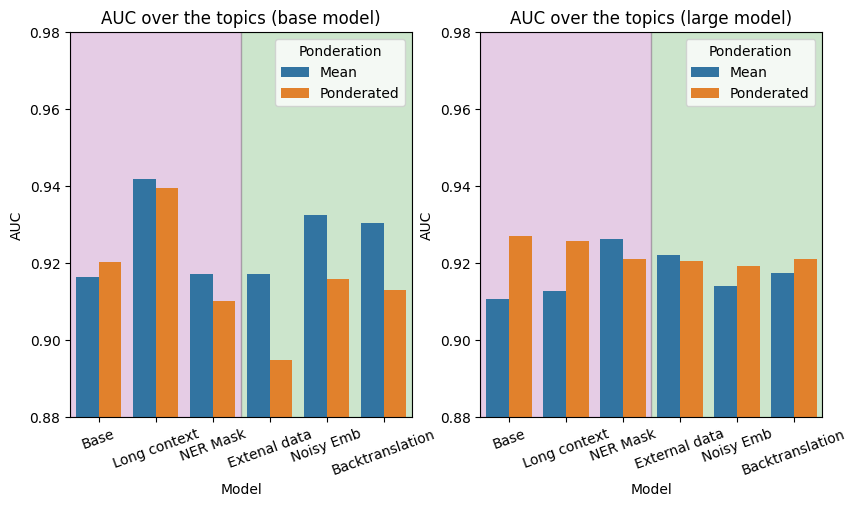

In [ ]:
from sklearn.metrics import roc_curve, auc

def get_auc_scores(models, nombres):
    print('F1-score over the topics')
    print('\tMean\tPonderated')
    data = pd.DataFrame(columns=['Model', 'AUC', 'Ponderation'])
    for model, nombre in zip(models, nombres):
        scores = []
        for topic in model['topic'].unique():
            subset = model[model['topic'] == topic]
            fpr, tpr, _ = roc_curve(subset['category'], subset['prob_fake'], pos_label='Fake')
            scores.append(auc(fpr, tpr))
        mean = np.mean(scores)
        fpr, tpr, _ = roc_curve(model['category'], model['prob_fake'], pos_label='Fake')
        pond = auc(fpr, tpr)
        data = pd.concat([data,pd.DataFrame({'Model': nombre, 'AUC': mean, 'Ponderation': 'Mean'}, index=[0])], ignore_index=True)
        data = pd.concat([data,pd.DataFrame({'Model': nombre, 'AUC': pond, 'Ponderation': 'Ponderated'}, index=[0])], ignore_index=True)
        print(f'{nombre}: {mean:.4f} | {pond:.4f}')
    print()
    return data

base_scores = get_auc_scores([base,full_length,ner,extra,noise,final],
                         ['Base', 'Long context', 'NER Mask', 'Extenal data', 'Noisy Emb', 'Backtranslation'])
large_scores = get_auc_scores([large_base, large_full, large_ner, large_extra, large_noise, large_final],
                            ['Base', 'Long context', 'NER Mask', 'External data', 'Noisy Emb', 'Backtranslation'])
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
ax = plt.gca()
ax.axvspan(2.5, 5.5, color='green', alpha=0.2)
ax.axvspan(-0.5, 2.5, color='purple', alpha=0.2)

chart = sns.barplot(x='Model', y='AUC', hue='Ponderation', data=base_scores)
for container in chart.containers:
    chart.bar_label(container, fmt='%.1f')
plt.title('AUC over the topics (base model)')
plt.xticks(rotation=20)
plt.ylim(0.88,0.98)

plt.subplot(1,3,2)
ax = plt.gca()
ax.axvspan(2.5, 5.5, color='green', alpha=0.2)
ax.axvspan(-0.5, 2.5, color='purple', alpha=0.2)

chart = sns.barplot(x='Model', y='AUC', hue='Ponderation', data=large_scores)
for container in chart.containers:
    chart.bar_label(container, fmt='%.1f')
plt.title('AUC over the topics (large model)')
plt.xticks(rotation=20)
plt.ylim(0.88,0.98)
plt.show()

## Significatividad

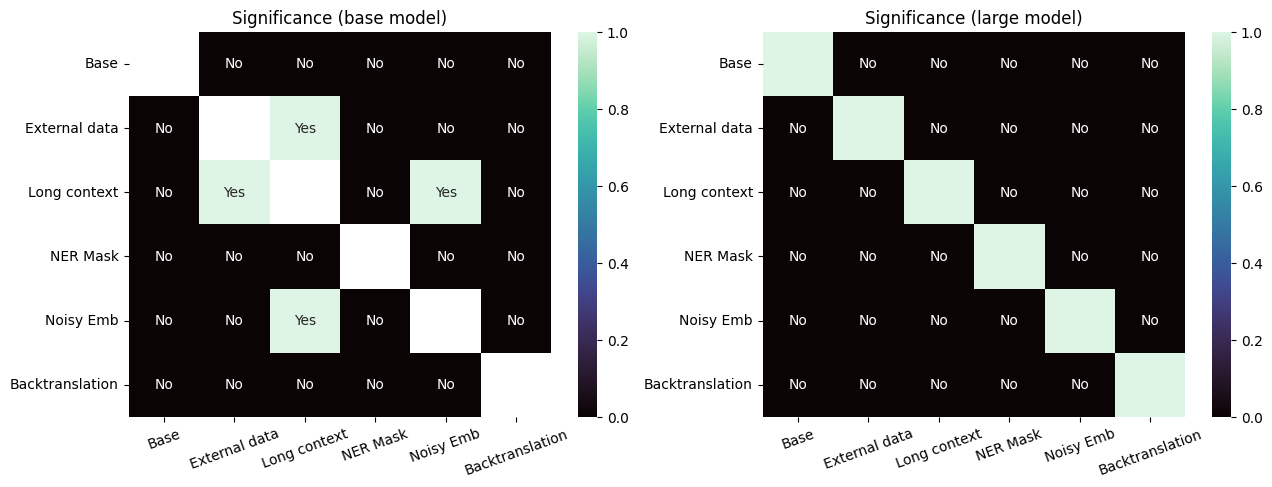

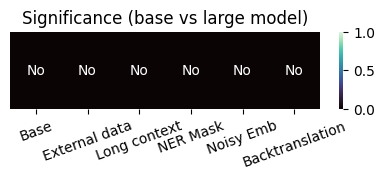

In [19]:
from testSignificance import calculateContingency, mcNemar

def get_scores(models):
    scores = []
    for model in models:
        gold = model['category'].apply(lambda x: 0 if x == 'Fake' else 1).to_numpy()
        pred = model['predictions'].apply(lambda x: 0 if x == 'Fake' else 1).to_numpy()
        scores.append(np.abs(gold - pred))
    return scores

def get_significance(scores, alpha=0.05):
    sig = np.zeros((len(scores), len(scores)))
    for i in range(len(scores)):
        for j in range(len(scores)):
            if i == j:
                sig[i,j] = True
            else:
                f_obs = calculateContingency(scores[i], scores[j], scores[i].shape[0])
                result = mcNemar(f_obs)
                sig[i,j] = result <= alpha
    return sig


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
base_scores = get_scores([base, extra, full_length, ner, noise, final])
base_sig = get_significance(base_scores)
annot = np.where(base_sig, 'Yes', 'No')
mask = np.zeros_like(base_sig)
for i in range(6):
    annot[i,i] = ''
    mask[i,i] = True
sns.heatmap(base_sig, annot=annot, cmap='mako',fmt='', mask=mask)
plt.title('Significance (base model)')
plt.xticks(ticks=np.arange(6)+0.5, labels=['Base', 'External data', 'Long context', 'NER Mask', 'Noisy Emb', 'Backtranslation'], rotation=20)
plt.yticks(ticks=np.arange(6)+0.5, labels=['Base', 'External data', 'Long context', 'NER Mask', 'Noisy Emb', 'Backtranslation'], rotation=0)

plt.subplot(1,2,2)
large_scores = get_scores([large_base, large_extra, large_full, large_ner, large_noise, large_final])
large_sig = get_significance(large_scores)
annot = np.where(large_sig, 'Yes', 'No')
for i in range(6):
    annot[i,i] = ''
sns.heatmap(large_sig, annot=annot, cmap='mako', fmt='')
plt.title('Significance (large model)')
plt.xticks(ticks=np.arange(6)+0.5, labels=['Base', 'External data', 'Long context', 'NER Mask', 'Noisy Emb', 'Backtranslation'], rotation=20)
plt.yticks(ticks=np.arange(6)+0.5, labels=['Base', 'External data', 'Long context', 'NER Mask', 'Noisy Emb', 'Backtranslation'], rotation=0)
plt.show()

plt.figure(figsize=(5,1))
mixed_sig = np.array([get_significance([base_scores[i], large_scores[i]])[0,1] for i in range(len(base_scores))]).reshape(1,6)
sns.heatmap(mixed_sig, annot=np.where(mixed_sig,'Yes','No'), cmap='mako', vmin=0, vmax=1, fmt='')
plt.title('Significance (base vs large model)')
plt.xticks(ticks=np.arange(6)+0.5, labels=['Base', 'External data', 'Long context', 'NER Mask', 'Noisy Emb', 'Backtranslation'], rotation=20)
plt.yticks([],[])
plt.show()